# Marketing Campaign Data Analysis

### Direct marketing vs Mass Marketing

### Direct marketing data

<p>We collected data from a Portuguese bank that used its own contact-center to do directed marketing campaigns. </p>
<p>The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 41188 customers (a customer can be contacted more than once). </p>
<p>During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable). For the whole database considered, there were 4640
successes (11% success rate).</p>

##### Input variables:<br>
**- client data:**<br>
1 - cust_id : customer id<br>
2 - age (numeric)<br>
3 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed')<br>
4 - marital : marital status (categorical: 'divorced','married','single')<br>
5 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree')<br>
6 - default: has credit in default? (categorical: 'no','yes')<br>
7 - mortgage: has housing loan? (categorical: 'no','yes')<br>
8 - loan: has personal loan? (categorical: 'no','yes')<br>
<br>
**- related with the last contact of the current campaign:**<br>
9 - contact_type: contact communication type (categorical: 'cellular','telephone')<br> 
10 - date: last contact date<br>
11 - duration: last contact duration, in seconds (numeric)<br>
<br>
**- other attributes:**<br>
12 - contact_num: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - p_days: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - p_outcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
<br>
##### Output variables:<br>
15 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## Import libraries and load dataset

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Inspired from stackoverflow.com/questions/25239958
from sklearn.base import BaseEstimator, TransformerMixin
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

print("current pandas version: " + pd.__version__)
print("current scikit-learn version: " + sklearn.__version__)
print("current seaborn version: " + sns.__version__)

current pandas version: 0.25.1
current scikit-learn version: 1.0.2
current seaborn version: 0.9.0


In [2]:
cust = pd.read_excel('cust_v2.xlsx')
contact = pd.read_csv('contact_v2.csv')

## Data overview

In [3]:
print(cust.shape)
print(contact.shape)

(42188, 8)
(41188, 8)


In [4]:
cust.head()

,cust_id,age,job,marital,education,default,mortgage,loan
0,78339,48,blue-collar,married,basic.6y,no,yes,no
1,94962,68,retired,married,university.degree,no,yes,no
2,71110,45,services,divorced,high.school,unknown,yes,no
3,97004,28,blue-collar,single,unknown,no,no,no
4,11598,37,blue-collar,married,professional.course,no,no,no


In [5]:
contact.head()

,cust_id,contact_type,duration,contact_num,p_days,p_outcome,y,date
0,44715,cellular,108,2,999,nonexistent,no,2008-08-02
1,62194,telephone,422,5,999,nonexistent,no,2008-06-03
2,25436,cellular,107,13,999,nonexistent,no,2008-07-16
3,39633,cellular,311,1,999,nonexistent,no,2008-07-15
4,92803,cellular,51,1,999,nonexistent,no,2008-11-09


## Data Preprocessing

In [6]:
# Merge two datasets
cmpn = pd.merge(left=contact, right=cust, how='inner', on='cust_id')

# Create new columns
cmpn['duration_mins'] = cmpn.duration / 60
cmpn['date1'] = pd.to_datetime(cmpn.date)
cmpn['yrmth'] = cmpn.date1.dt.strftime('%Y%m')
cmpn = cmpn.drop(['date'], axis=1)
cmpn = cmpn.rename(columns={'date1':'date'})

# Drop duplicates and not-in-use column
cmpn = cmpn.drop_duplicates()
cmpn = cmpn.drop('default', axis=1)

In [7]:
cmpn.shape

(41188, 16)

In [8]:
cmpn.dtypes

cust_id                   int64
contact_type             object
duration                  int64
contact_num               int64
p_days                    int64
p_outcome                object
y                        object
age                       int64
job                      object
marital                  object
education                object
mortgage                 object
loan                     object
duration_mins           float64
date             datetime64[ns]
yrmth                    object
dtype: object

In [9]:
cmpn.head()

,cust_id,contact_type,duration,contact_num,p_days,p_outcome,y,age,job,marital,education,mortgage,loan,duration_mins,date,yrmth
0,44715,cellular,108,2,999,nonexistent,no,52,blue-collar,married,basic.6y,yes,no,1.800000,2008-08-02,200808
1,62194,telephone,422,5,999,nonexistent,no,31,management,married,university.degree,yes,no,7.033333,2008-06-03,200806
2,25436,cellular,107,13,999,nonexistent,no,36,entrepreneur,married,university.degree,yes,no,1.783333,2008-07-16,200807
3,39633,cellular,311,1,999,nonexistent,no,44,blue-collar,married,basic.4y,yes,no,5.183333,2008-07-15,200807
4,92803,cellular,51,1,999,nonexistent,no,32,admin.,married,university.degree,yes,yes,0.850000,2008-11-09,200811


In [10]:
col_type = cmpn.dtypes
var_cat = col_type[col_type=='object'].index.tolist()
var_num = col_type[col_type!='object'].index.tolist()
var_key = ['cust_id','date','yrmth']

print(var_cat)
print(var_num)
print(var_key)

var_num = [item for item in var_num if item not in var_key]
print(var_num, len(var_num))
var_cat = [item for item in var_cat if item not in var_key]
print(var_cat, len(var_cat))

# Get categorical variable distribution
for i, var in enumerate(var_cat):
    print(str(i) + " - " + str(var) + ":")
    print(cmpn[var].value_counts(dropna=False))
    print('-------------------------------------------------------')
    print()

['contact_type', 'p_outcome', 'y', 'job', 'marital', 'education', 'mortgage', 'loan', 'yrmth']
['cust_id', 'duration', 'contact_num', 'p_days', 'age', 'duration_mins', 'date']
['cust_id', 'date', 'yrmth']
['duration', 'contact_num', 'p_days', 'age', 'duration_mins'] 5
['contact_type', 'p_outcome', 'y', 'job', 'marital', 'education', 'mortgage', 'loan'] 8
0 - contact_type:
cellular     26144
telephone    15044
Name: contact_type, dtype: int64
-------------------------------------------------------

1 - p_outcome:
nonexistent    35563
failure         4252
success         1373
Name: p_outcome, dtype: int64
-------------------------------------------------------

2 - y:
no     36548
yes     4640
Name: y, dtype: int64
-------------------------------------------------------

3 - job:
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unem

### Check Missing Value

In [11]:
cmpn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 16 columns):
cust_id          41188 non-null int64
contact_type     41188 non-null object
duration         41188 non-null int64
contact_num      41188 non-null int64
p_days           41188 non-null int64
p_outcome        41188 non-null object
y                41188 non-null object
age              41188 non-null int64
job              41188 non-null object
marital          41188 non-null object
education        41188 non-null object
mortgage         41188 non-null object
loan             41188 non-null object
duration_mins    41188 non-null float64
date             41188 non-null datetime64[ns]
yrmth            41188 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(9)
memory usage: 5.3+ MB


In [12]:
MissingSummary = pd.concat([cmpn.dtypes, cmpn.isnull().any(axis=0), cmpn.isnull().sum(axis=0)], axis=1)
MissingSummary.columns = ['FeatureType','IsMissing', 'MissingCnt']
MissingSummary

,FeatureType,IsMissing,MissingCnt
cust_id,int64,False,0
contact_type,object,False,0
duration,int64,False,0
contact_num,int64,False,0
p_days,int64,False,0
p_outcome,object,False,0
y,object,False,0
age,int64,False,0
job,object,False,0
marital,object,False,0


### Impute Numeric Values

In [13]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

In [14]:
# Create a SimpleImputer object with strategy = 'median'
# sk learn specific requirement -- create an object that tells sklearn to impute the data using median
imputer = SimpleImputer(strategy="median")

# Select the numerical columns only
cmpn_num = cmpn[var_num]
mindex = cmpn_num[cmpn_num.age.isna()].head().index
cmpn_num[cmpn_num.age.isna()].head()

X = imputer.fit_transform(cmpn_num)
cmpn_num_df = pd.DataFrame(X, columns=cmpn_num.columns)

In [15]:
cmpn_num_df.loc[mindex]

,duration,contact_num,p_days,age,duration_mins


### Impute Categorical Values

In [16]:
cmpn_cat = cmpn[var_cat]

mindex = cmpn_cat[cmpn_cat.isnull().any(axis='columns')].head().index

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)
    
MI = MostFrequentImputer()
MI.fit(cmpn_cat)

cmpn_cat_df = MI.transform(cmpn_cat)
cmpn_cat_df.loc[mindex]

,contact_type,p_outcome,y,job,marital,education,mortgage,loan


In [17]:
[cmpn.columns]

[Index(['cust_id', 'contact_type', 'duration', 'contact_num', 'p_days',
        'p_outcome', 'y', 'age', 'job', 'marital', 'education', 'mortgage',
        'loan', 'duration_mins', 'date', 'yrmth'],
       dtype='object')]

In [18]:
cmpn = pd.concat([cmpn[var_key],cmpn_num_df,cmpn_cat_df], axis=1)[cmpn.columns]

## Seasonality Check on y

In [19]:
# Add month column
cmpn['month'] = cmpn.date.dt.month
cmpn.month.value_counts()

5     13769
7      7174
8      6178
6      5318
11     4101
4      2632
10      718
9       570
3       546
12      182
Name: month, dtype: int64

In [20]:
res = cmpn.pivot_table(values='cust_id', index='month', columns='y', aggfunc='count', margins=True)
res

y,no,yes,All
month,,,
3,270,276,546
4,2093,539,2632
5,12883,886,13769
6,4759,559,5318
7,6525,649,7174
8,5523,655,6178
9,314,256,570
10,403,315,718
11,3685,416,4101


In [21]:
# Add response rate
res['response_rate'] = res.yes / res.All
res1 = res.iloc[:-1,:].sort_values(by='response_rate', ascending=False)
res2 = res.iloc[-1:,:]

pd.concat([res1,res2], axis=0)

y,no,yes,All,response_rate
month,,,,
3,270,276,546,0.505495
12,93,89,182,0.489011
9,314,256,570,0.449123
10,403,315,718,0.438719
4,2093,539,2632,0.204787
8,5523,655,6178,0.106021
6,4759,559,5318,0.105115
11,3685,416,4101,0.101439
7,6525,649,7174,0.090466


## Discover and Visualize the Data to Gain Insights

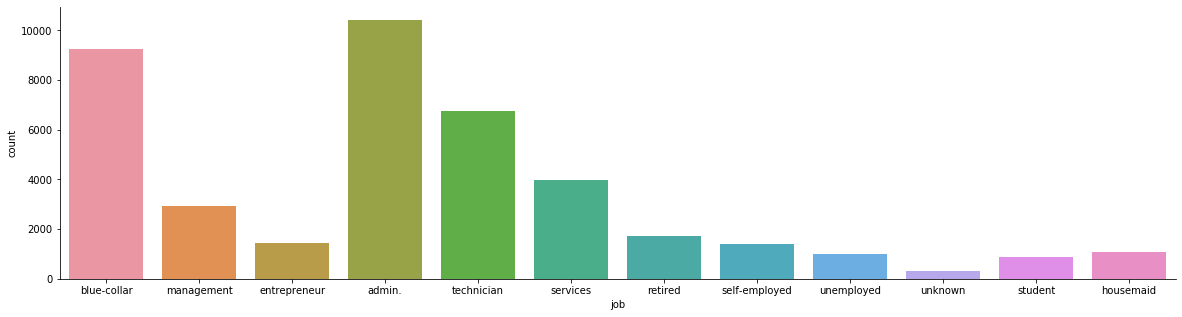

In [22]:
plt.subplots(figsize=(20,5))
sns.countplot(x = 'job', data = cmpn)
sns.despine() ##remove black line

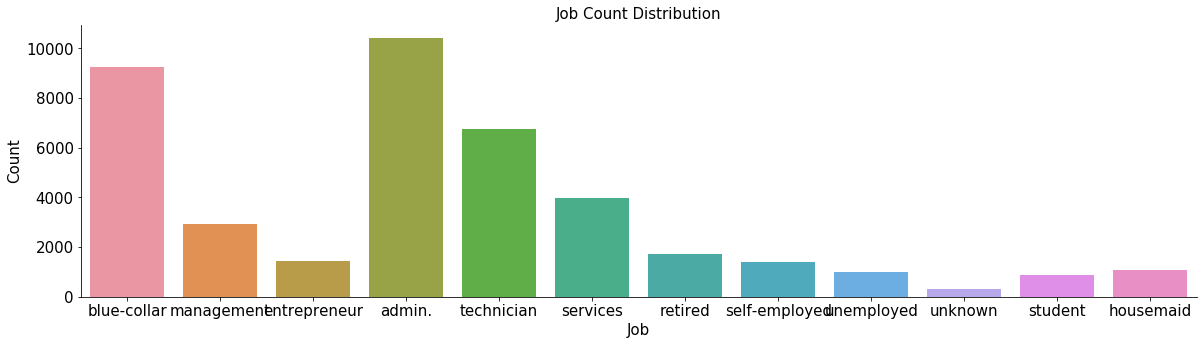

In [23]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.countplot(x = 'job', data = cmpn, ax = ax1)
ax1.set_xlabel('Job', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title('Job Count Distribution', fontsize=15)
ax1.tick_params(labelsize=15)
sns.despine()

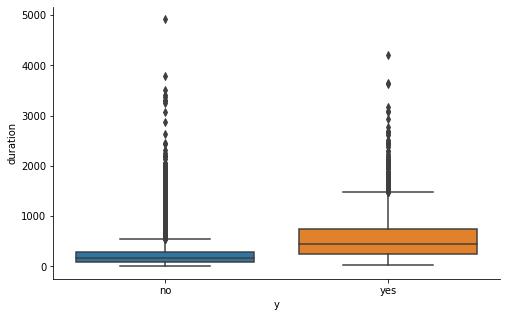

In [24]:
plt.subplots(figsize=(8,5))
sns.boxplot(x='y', y='duration', data=cmpn)
sns.despine()

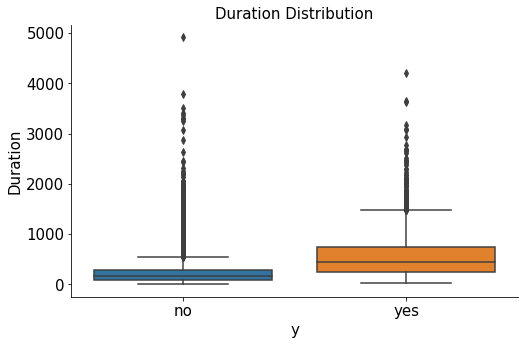

In [25]:
fig, ax1= plt.subplots(figsize=(8,5))
sns.boxplot(x='y', y='duration', data=cmpn, ax=ax1)
ax1.set_xlabel('y', fontsize=15)
ax1.set_ylabel('Duration', fontsize=15)
ax1.set_title('Duration Distribution', fontsize=15)
ax1.tick_params(labelsize=15)
sns.despine()

## Response Prediction

In [26]:
df = cmpn.copy()

In [27]:
# Change the outcome to binary, i.e. 0 and 1
df.loc[df.y=='no','y'] = 0
df.loc[df.y=='yes','y'] = 1
df['y'] = df.y.astype('int64')
df.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

#### Categorical variable processing: One-hot encoding

In [28]:
# response rate by different categorical variables
for var in ['month']+var_cat[:-1]:
    df1 = pd.crosstab(cmpn[var], cmpn.y, margins= True)
    df1.reset_index(inplace = True)
    df1.columns.name = ''
    df1['num_contact'] = df1.no + df1.yes
    df1['response_rate'] = df1.yes / df1.num_contact
    df1 = df1[[var, 'num_contact', 'response_rate']]
    df1.sort_values(by='response_rate', ascending=False, inplace=True)
    print(str(var) + ":")
    print(df1)
    print('-------------------------------------------------------------------------')

month:
   month  num_contact  response_rate
0      3          546       0.505495
9     12          182       0.489011
6      9          570       0.449123
7     10          718       0.438719
1      4         2632       0.204787
10   All        41188       0.112654
5      8         6178       0.106021
3      6         5318       0.105115
8     11         4101       0.101439
4      7         7174       0.090466
2      5        13769       0.064347
-------------------------------------------------------------------------
contact_type:
  contact_type  num_contact  response_rate
0     cellular        26144       0.147376
2          All        41188       0.112654
1    telephone        15044       0.052313
-------------------------------------------------------------------------
p_outcome:
     p_outcome  num_contact  response_rate
2      success         1373       0.651129
0      failure         4252       0.142286
3          All        41188       0.112654
1  nonexistent        35563     

In [29]:
df.loc[df.month.isin([3,9,10,12]),'seasonality'] = 1
df.loc[~df.month.isin([3,9,10,12]),'seasonality'] = 0
df.loc[:,'seasonality'] = df.seasonality.astype('int64')
print(df.seasonality.value_counts(dropna=False))
print(df.seasonality.dtypes)

0    39172
1     2016
Name: seasonality, dtype: int64
int64


In [30]:
df.loc[df.job=='student','student'] = 1
df.loc[df.job!='student','student'] = 0
df.loc[:,'student'] = df.student.astype('int64')
print(df.student.value_counts(dropna=False))
print(df.student.dtypes)

0    40313
1      875
Name: student, dtype: int64
int64


In [31]:
df.loc[df.job=='retired','retired'] = 1
df.loc[~(df.job=='retired'),'retired'] = 0
df.loc[:,'retired'] = df.retired.astype('int64')
print(df.retired.value_counts(dropna=False))
print(df.retired.dtypes)

0    39468
1     1720
Name: retired, dtype: int64
int64


In [32]:
df.loc[df.p_outcome=='success','success'] = 1
df.loc[df.p_outcome!='success','success'] = 0
df.loc[:,'success'] = df.success.astype('int64')
print(df.success.value_counts(dropna=False))
print(df.success.dtypes)

0    39815
1     1373
Name: success, dtype: int64
int64


In [33]:
# Training Data / Test data 80% vs. 20%
X = df[['student','retired','seasonality','success',
         'age','duration','contact_num','p_days']]
y = df.y

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=824)

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=7, random_state=824)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=824)

### Feature Importance

In [36]:
for name, importance in zip(X_train.columns.tolist(), rf_clf.feature_importances_):
    print('%s = %.3f' %(name, importance))

student = 0.013
retired = 0.007
seasonality = 0.124
success = 0.097
age = 0.069
duration = 0.498
contact_num = 0.015
p_days = 0.176


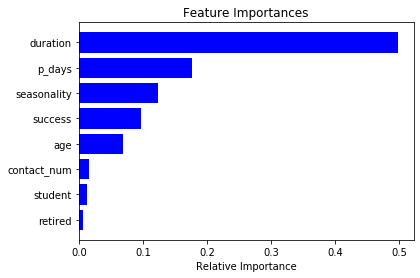

In [37]:
features = X_train.columns.tolist()
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Model Evaluation

In [38]:
print("RF train accuracy: %0.3f" % rf_clf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf_clf.score(X_test, y_test))

RF train accuracy: 0.909
RF test accuracy: 0.906


In [39]:
from sklearn.metrics import roc_auc_score
print('RF train AUC : %s' % roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:,1]))
print('RF test AUC: %s' % roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1]))

RF train AUC : 0.9091611713790912
RF test AUC: 0.8951270015038925
